In [4]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
import matplotlib.transforms as mtransforms
from random import shuffle
from model_parameters import *
from io import StringIO

# HV function 
def heav(X):
    if X <= 0:
        return 0
    elif X>0:
        return 1

In [7]:
# node = 16
Tdt = """
    cln3=0
    whi5=1
    sbf=0
    cln2=0
    mbf=0
    clb5=0
    ori=0
    clb2G=0
    cdc5=0
    mcm1=0
    clb2M=0
    sac=0
    cdc20=0
    spoc=0
    cdc14=0
    swi5=0
    cdh1=1
    sic1=1
    nrm1=0
"""
node_name = ["cln3","whi5","sbf","cln2", "mbf","clb5","ori", "clb2G", "cdc5","mcm1","clb2M","sac", "cdc20","spoc","cdc14","swi5","cdh1","sic1","nrm1"]
df = pd.read_csv(StringIO(Tdt), sep="=",header=None).T.iloc[1:,:]
df.columns = node_name
df["size"]= 0.65
init_pop = pd.concat([df]*100) # number of repeats = 100
init_pop["type"]=["M"]*100
init_pop["spn_progress"]=0
init_pop["spoc_progress"]=0
init_pop["time"]=0

In [5]:
prot_activity = []
for index_cell in range(init_pop.shape[0]):
    
    """
    Model parameters
    """
    r_glucose =0.0077
    f_mean_glucose = 0.55
    f_CV_glucose = 0.1 
    cell_size = 0.65
    S0_mean = 0.60 
    S0_CV = 0.1 
    SPO_mean = 0.07 
    SPO_CV = 0.03
    SPN_mean = 0.07 
    SPN_CV = 0.03 
    tr_max = 500
    S0_log = np.random.lognormal(np.log(S0_mean),S0_CV,1)[0]


    """
    initial state 
    """
    init_state = np.array(init_pop.iloc[index_cell,:19].tolist())
    for n, val in enumerate(init_state):
        globals()[node_name[n]] = int(val) 

    cell_size = init_pop.iloc[index_cell,19]
    type_ = init_pop.iloc[index_cell,20]
    spn_progress = init_pop.iloc[index_cell,21]
    spoc_progress = init_pop.iloc[index_cell,22]
    tr = init_pop.iloc[index_cell,23]
    
    
    while True:

        if tr >= tr_max:
            break

        """
        W function of Boolean variables
        """
        cln3_sum = (cell_size >= S0_log)
        whi5_sum = k60 + k61*cdc14 - k62*cln2 - k63*cln3 
        sbf_sum =  k45 + k47*clb5 + k48*cln2 + k49*cln3 - k46*clb2G - k50*whi5 
        cln2_sum = k30 + k31*mbf + k32*sbf 
        mbf_sum  = k33 + k35*clb5 + k36*cln2 + k37*cln3 - k34*clb2G - k38*nrm1 
        clb5_sum = k25 + k27*mbf + k28*sbf - k29*sic1 - k26*cdc20 
        clb2G_sum = k19 - k20*cdh1 - k21*sic1
        clb2M_sum =  k22 + k24*mcm1 - k23*cdc20
        mcm1_sum = k39 + k41*clb2M + k40*clb2G
        cdc5_sum = k9 + k11*clb2G + k12*clb2M - k10*cdh1 
        cdc20_sum =  k6 + k7*mcm1 - k8*sac 
        cdc14_sum = k1 + k2*cdc5 - k5*spoc - k4*sac - k3*clb2M
        swi5_sum =  k57 + k58*cdc14 + k59*mcm1 
        cdh1_sum = k13 + k14*cdc14 - k16*clb2M - k17*clb5 - k18*cln2 - k15*clb2G
        sic1_sum = k51 + k56*swi5 - k53*clb2M - k54*clb5 - k55*cln2 - k52*clb2G
        nrm1_sum = k42 - k43*cdh1 + k44*mbf

     
        """
        Binarized by Heaviside
        """
        cln3_new = heav(cln3_sum)
        whi5_new = heav(whi5_sum)
        sbf_new = heav(sbf_sum)
        cln2_new = heav(cln2_sum)
        mbf_new = heav(mbf_sum)
        clb5_new = heav(clb5_sum)
        mcm1_new = heav(mcm1_sum)
        clb2M_new = heav(clb2M_sum)
        cdc20_new = heav(cdc20_sum) 
        cdc5_new = heav(cdc5_sum)
        cdc14_new = heav(cdc14_sum) 
        swi5_new = heav(swi5_sum)
        cdh1_new = heav(cdh1_sum)
        sic1_new = heav(sic1_sum)
        clb2G_new = heav(clb2G_sum)
        nrm1_new = heav(nrm1_sum)



        """
        Which protein is changed ?
        """

        cln3_update = cln3_new - cln3
        whi5_update = whi5_new - whi5
        sbf_update =  sbf_new - sbf
        cln2_update = cln2_new - cln2
        mbf_update  = mbf_new - mbf
        clb5_update = clb5_new - clb5
        mcm1_update = mcm1_new - mcm1
        clb2M_update = clb2M_new - clb2M
        cdc20_update = cdc20_new - cdc20
        cdc5_update = cdc5_new - cdc5
        cdc14_update = cdc14_new - cdc14
        swi5_update = swi5_new - swi5
        cdh1_update = cdh1_new - cdh1
        sic1_update = sic1_new - sic1
        clb2G_update = clb2G_new - clb2G
        nrm1_update = nrm1_new - nrm1



        """
        Propensity Function
        """

        x1 = abs(cln3_update)
        x2 = x1 + abs(whi5_update)
        x3 = x2 + abs(sbf_update)
        x4 = x3 + abs(cln2_update)
        x5 = x4 + abs(mbf_update)
        x6 = x5 + abs(clb5_update)
        x7 = x6 + abs(mcm1_update)
        x8 = x7 + abs(clb2M_update)
        x9 = x8 + abs(cdc20_update)
        x10 = x9 + abs(cdc5_update)
        x11 = x10 + abs(cdc14_update)
        x12 = x11 + abs(swi5_update)
        x13 = x12 + abs(cdh1_update)
        x14 = x13 + abs(sic1_update)
        x15 = x14 + abs(clb2G_update)
        x16 = x15 + abs(nrm1_update)



        """
        if state isn't change, set to G1 state (x14 = 1)
        """

        if x16 == 0:
            x17 = 1
        else:
            x17 = x16


        """
        Selecting a single variable to change with a uniform asynchronous update
        """
        sel = random.uniform(0,1)*x17

        y1 = (sel<=x1)
        y2 = (sel>x1)&(sel<=x2)
        y3 = (sel>x2)&(sel<=x3)
        y4 = (sel>x3)&(sel<=x4)
        y5 = (sel>x4)&(sel<=x5)
        y6 = (sel>x5)&(sel<=x6)
        y7 = (sel>x6)&(sel<=x7)
        y8 = (sel>x7)&(sel<=x8)
        y9 = (sel>x8)&(sel<=x9)
        y10 = (sel>x9)&(sel<=x10)
        y11 = (sel>x10)&(sel<=x11)
        y12 = (sel>x11)&(sel<=x12)
        y13 = (sel>x12)&(sel<=x13)
        y14 = (sel>x13)&(sel<=x14)
        y15 = (sel>x14)&(sel<=x15)
        y16 = (sel>x15)&(sel<=x16)
        y17 = (sel>x16)


        """
        update time
        """
        delt = np.random.gamma(3,0.3)
        tr = tr + delt

        """
        DIVISION EVENT
        """

        if(clb2G == 1 and clb2G_new == 0 and y15 == 1):

            f = np.random.lognormal(np.log(f_mean_glucose),f_CV_glucose, 1)[0]
            cell_size = cell_size*math.exp(r_glucose*delt) * (f) 
            S0_log = np.random.lognormal(np.log(S0_mean),S0_CV,1)[0]
            
        else:

            cell_size = cell_size*math.exp(r_glucose*delt)


        """
        Update variable based on Propensity Function
        """

        cln3 = cln3 + cln3_update*y1
        whi5 = whi5 + whi5_update*y2
        sbf =  sbf + sbf_update*y3
        cln2 = cln2 + cln2_update*y4
        mbf =  mbf + mbf_update*y5
        clb5 = clb5 + clb5_update*y6
        mcm1 = mcm1 + mcm1_update*y7
        clb2M = clb2M + clb2M_update *y8
        cdc20 = cdc20 + cdc20_update*y9
        cdc5 = cdc5 + cdc5_update*y10
        cdc14 = cdc14 + cdc14_update*y11
        swi5 = swi5 + swi5_update*y12
        cdh1 = cdh1 + cdh1_update*y13
        sic1 = sic1 + sic1_update*y14
        clb2G = clb2G + clb2G_update*y15
        nrm1 = nrm1 + nrm1_update*y16



        """
        Switch cln3/whi5 based on cell size
        """
        if cell_size < S0_log:
            cln3,whi5 = 0,1
        else:
            cln3,whi5 = 1,0


        """
        ORI begin
        """
        if (clb5 == 1 or clb2M == 1 or clb2G == 1):
            ori = 1
        else:
            ori = 0


        """
        SAC Checkpoint
        """

        if (ori == 1 and spn_progress < 1):
            sac=1
        else:
            sac=0


        if(clb2M == 1 and sac == 1):
            num =  np.random.lognormal(np.log(SPN_mean),SPN_CV,1)[0]
            spn_progress += num
            if spn_progress >= 1:
                spn_progress = 1

        elif clb2G_update == -1 and clb2G == 0 and y15 == 1:
            spn_progress = 0


        """
        SPoC Checkpoint
        """

        if (cdc20 == 1 and spoc_progress < 1):
            spoc = 1
        elif spoc_progress >= 1:
            spoc = 0

        if(cdc20 == 1):
            num = np.random.lognormal(np.log(SPO_mean),SPO_CV,1)[0]
            spoc_progress += num
            if spoc_progress >= 1:
                spoc_progress = 1
        else:
            spoc_progress = 0


        collect_ = [cln3,whi5,sbf,cln2,mbf,clb5,ori,clb2G,cdc5,mcm1,clb2M,
                    sac,cdc20,spoc,cdc14,swi5,cdh1,sic1,nrm1,tr,cell_size,index_cell]
        
        prot_activity.append(collect_)

In [6]:
df_res = pd.DataFrame(prot_activity,columns=node_name+["time","size","idx"])
df_melt = df_res.melt(id_vars=["idx","time"])
#df_melt.to_csv("../data/Fig4A.csv")

In [8]:
cnt=0
res_list = []
for j in range(500):
    cnt += 1
    df3 = df_melt.query("time <= @cnt").groupby(['variable','idx']).tail(1)
    df4 = df3[["idx","variable","value"]]
    df4["time"] = cnt
    res_list.append(df4)

In [9]:
df_ave = pd.concat(res_list)
df_ave['variable'] = df_ave['variable'].str.replace('size','cell size')
#fx = ['clb2M','sic1','cln2','cdh1','cell size']
#df_ave.query("variable == @fx").reset_index().to_csv("../data/fig4B.csv")

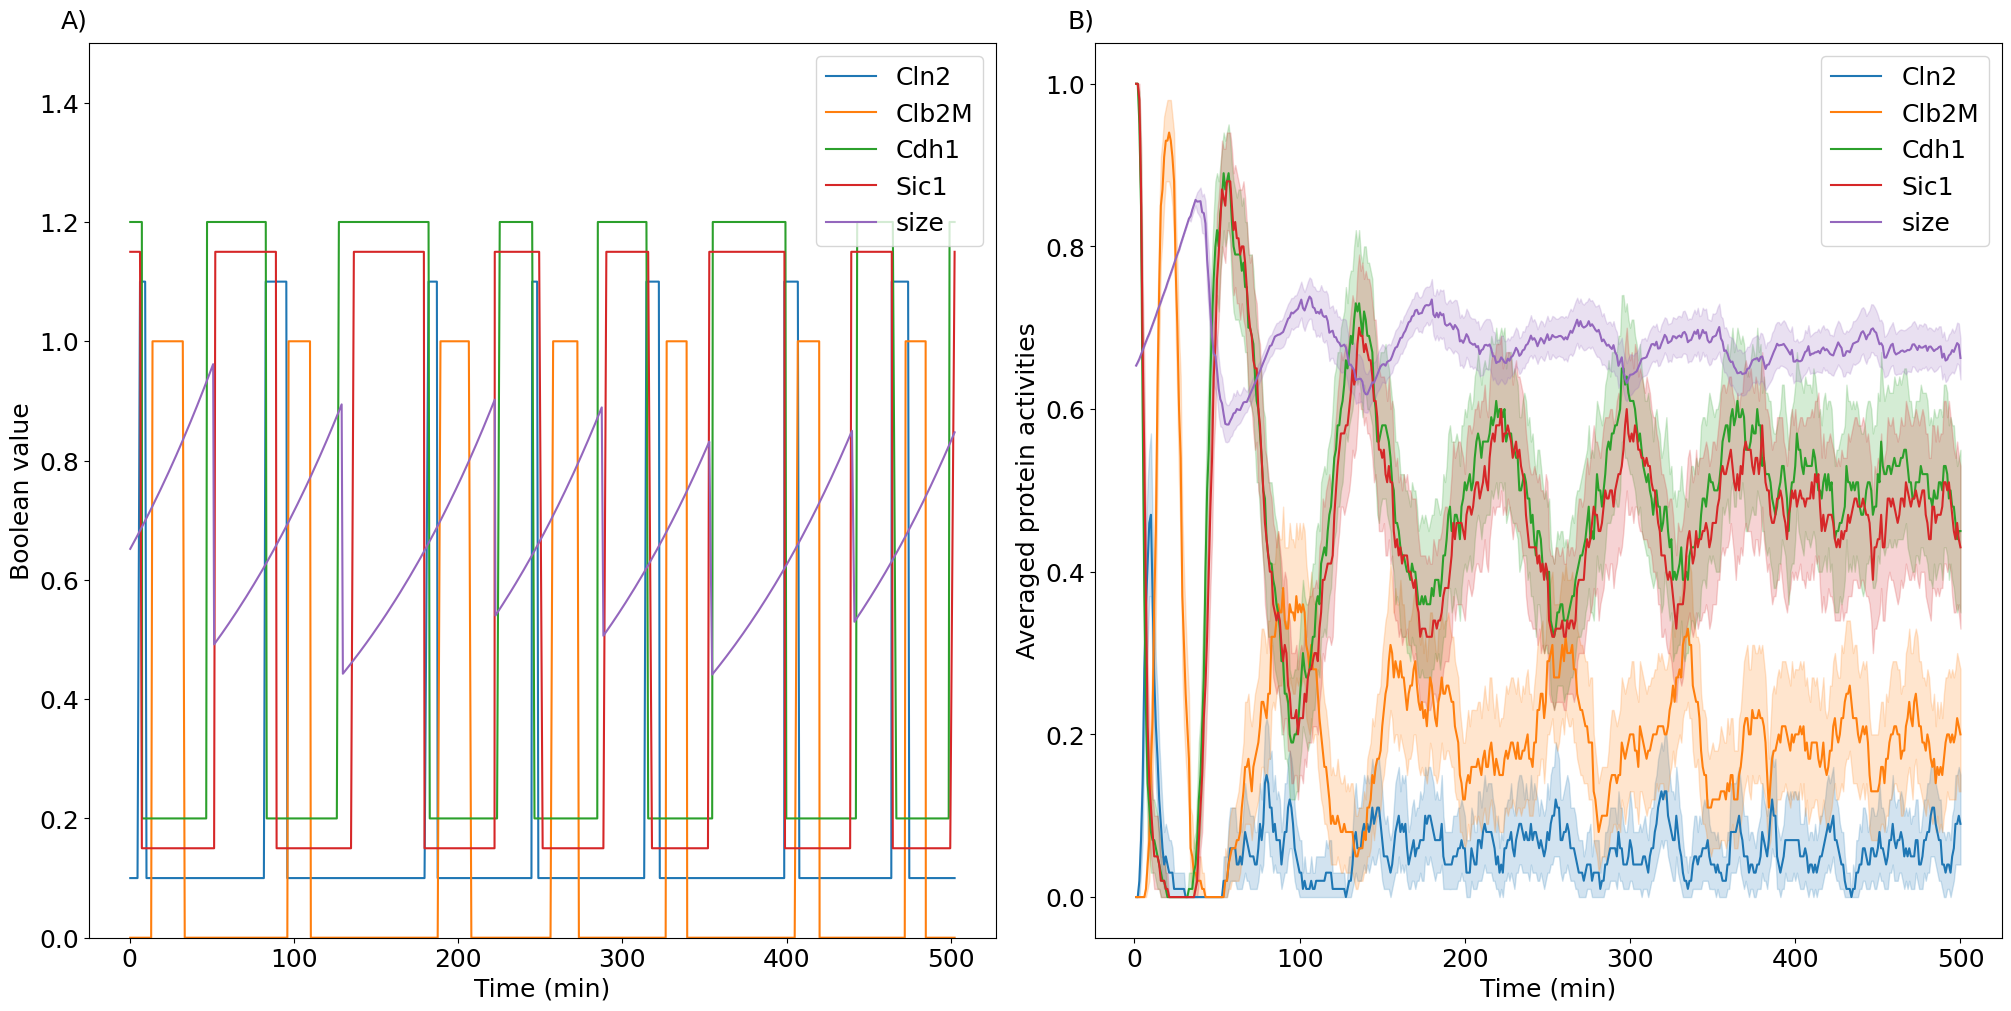

In [3]:
#Fig4 plot
fig = plt.figure(layout= 'constrained', figsize=(20,10))
axs = fig.subplot_mosaic([['A)', 'B)']])

XX=18
single = pd.read_csv("../data/fig4A.csv").query("idx == 42")
fx = ['clb2','sic1','cln2','cdh1','size']
df_ave2 = single.query("variable == @fx").reset_index().replace({'variable' : { 'cln2': 'Cln2', 
                                                                                'clb2': 'Clb2M',
                                                                                'cdh1': 'Cdh1',
                                                                                'sic1':'Sic1'}})
df_ave2["value"] = np.where(df_ave2["variable"] == 'Cdh1',df_ave2["value"]+0.2,df_ave2["value"])
df_ave2["value"] = np.where(df_ave2["variable"] == 'Sic1',df_ave2["value"]+0.15,df_ave2["value"])
df_ave2["value"] = np.where(df_ave2["variable"] == 'Cln2',df_ave2["value"]+0.1,df_ave2["value"])
sns.lineplot(data=df_ave2, x="time", y="value", hue="variable",ax=axs['A)'])
axs['A)'].legend(loc="upper right",fontsize=XX)
axs['A)'].set_xlabel("Time (min)",fontsize=XX)
axs['A)'].set_ylabel("Boolean value",fontsize=XX)
axs['A)'].set_ylim(0, 1.5)
axs['A)'].tick_params(labelsize=XX)

fx = ['clb2','sic1','cln2','cdh1','cell size']
df_aves = pd.read_csv("../data/fig4B.csv").query("variable == @fx").replace({'variable' : { 'cln2': 'Cln2', 
                                                                    'clb2': 'Clb2M',
                                                                    'cdh1': 'Cdh1',
                                                                    'sic1':'Sic1'}})

df_aves["variable"] = df_aves["variable"].str.replace('cell size','size')
sns.lineplot(data=df_aves, x="time", y="value", hue="variable",ax=axs['B)'])
axs['B)'].legend(loc="upper right",fontsize=XX)
axs['B)'].set_xlabel("Time (min)",fontsize=XX)
axs['B)'].set_ylabel("Averaged protein activities",fontsize=XX)
axs['B)'].tick_params(labelsize=XX)

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize=XX, va='bottom')

    
plt.savefig('../figures/Fig4.pdf',format="pdf", bbox_inches="tight")
plt.show()